### Dataset Description
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.
![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/about-us-home-credit.jpg)

#### Modules

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from fancyimpute import MICE
from sklearn.preprocessing import StandardScaler
#from impyute.imputation.cs import mic

In [4]:
"""
Config Dict
"""

from collections import defaultdict

CONFIG = defaultdict()

CONFIG['DATASET_PATH'] = './data/'
CONFIG['TEST_SIZE'] = 0.2
CONFIG['RANDOM_STATE'] = 25
CONFIG['STRAT_TYPE'] = 'TARGET'

### Load Dataset

In [5]:
def load_credit_application_data(config=CONFIG):
    dataset_path = CONFIG['DATASET_PATH']
    csv_path = os.path.join(dataset_path, "application_train.csv")
    return pd.read_csv(csv_path)

In [7]:
credit = load_credit_application_data()
credit.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
# looking for number/type of values for text data
print(credit['NAME_CONTRACT_TYPE'].value_counts())

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


In [7]:
# Looking at at the description of the data
credit.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


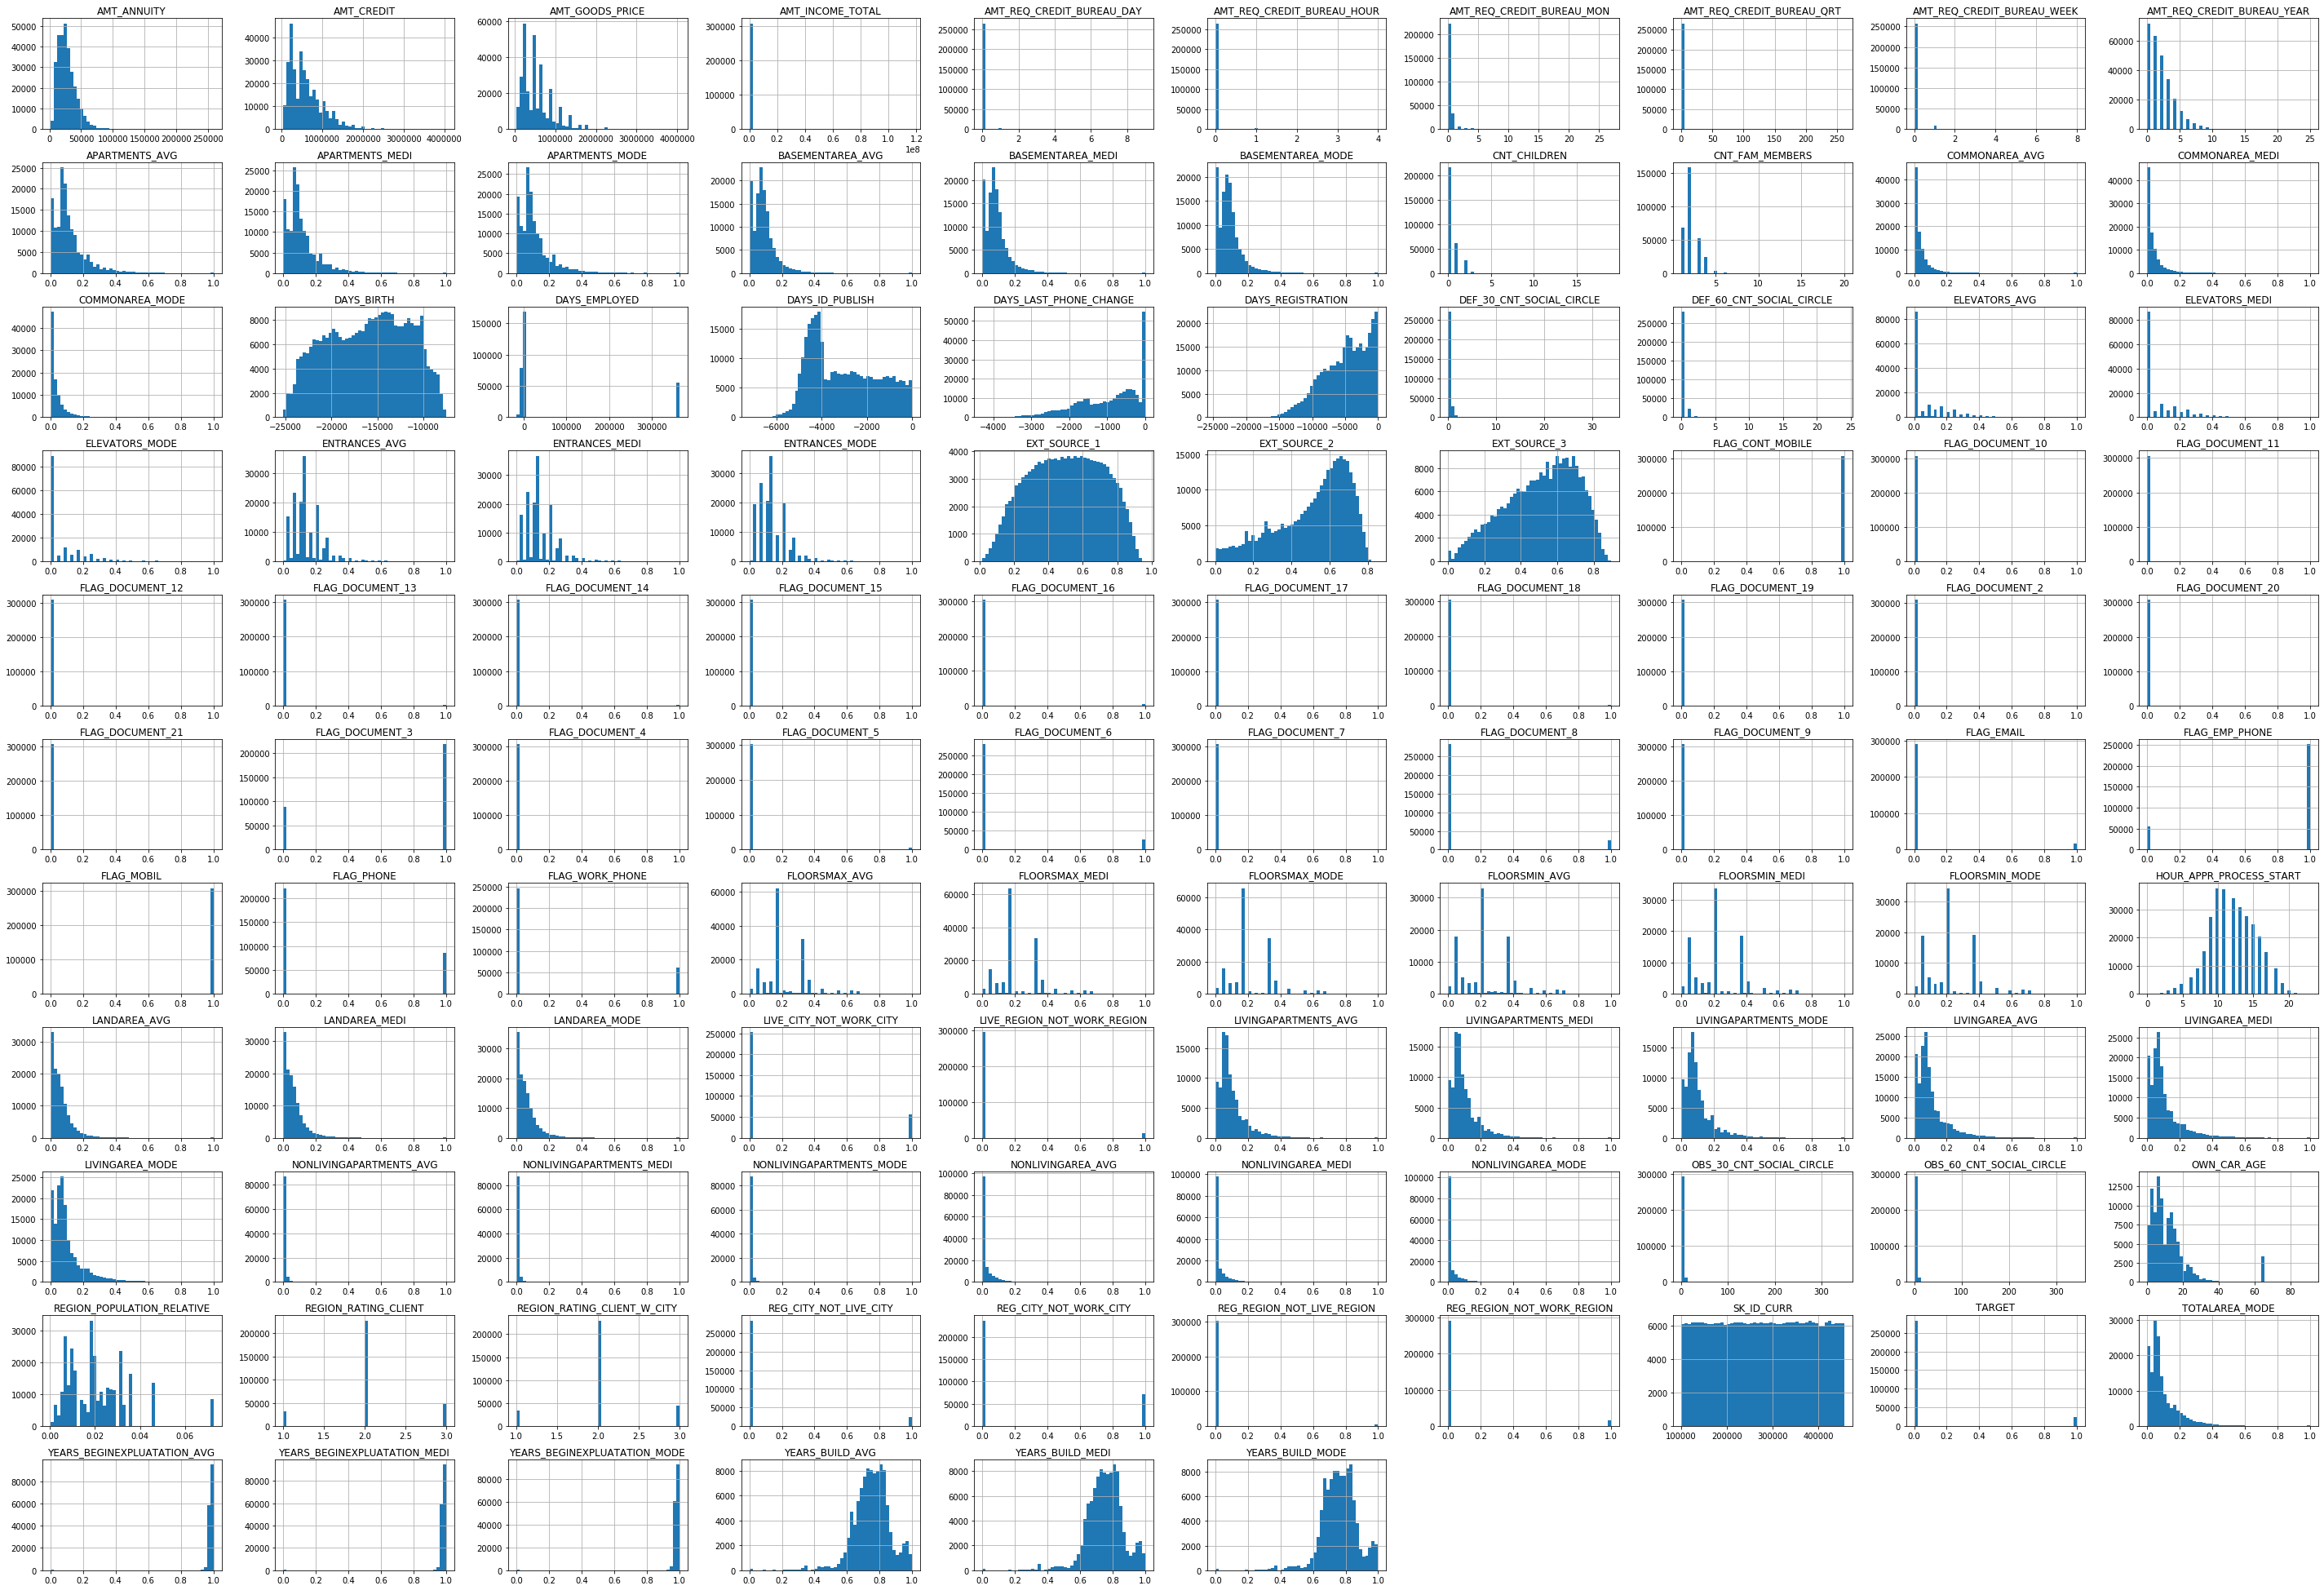

In [8]:
%matplotlib inline
credit.hist(bins=50, figsize=(50,35))
plt.show()

There are various types of data:
  1. Object (categorical data)
  2. int64
  3. float64
  
The categorical data needs to be taken care of

    NAME_CONTRACT_TYPE = cash loans/ revolving loans
    CODE_GENDER = M/F
    FLAG_OWN_CAR = Y/N
    FLAG_OWN_REALTY = Y/N
    NAME_TYPE_SUITE = unaccompanied/family/Spouse, partner/children/other
    NAME_INCOME_TYPE = Working/Commercial associate/Pensioner/State servant
    NAME_EDUCATION_TYPE = Secondary / secondary special/Secondary / secondary special/Higher education/Incomplete higher/Lower secondary
    NAME_FAMILY_STATUS = Married/Single / not married/Civil marriage/Separated
    NAME_HOUSING_TYPE = House / apartment/With parents/Municipal apartment/Rented apartment
    OCCUPATION_TYPE = [null]/Laborers/Sales staff/Core staff/Other
    WEEKDAY_APPR_PROCESS_START = M/T/W...
    ORGANIZATION_TYPE = Business Entity Type 3/XNA/Self-employed/Other
    FONDKAPREMONT_MODE = [null]/reg oper account/reg oper spec account/not specified
    HOUSETYPE_MODE = [null]/block of flats/specific housing/specific housing/terraced house
    WALLSMATERIAL_MODE = [null]/Panel/Stone, brick/Block
    EMERGENCYSTATE_MODE = Boolean
    
Before the dataset imputation can be done the categorical data needs to be taken care of
  

In [9]:
credit.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

In [8]:
column_titles = list(credit)
print("Total Columns/features = {}".format(len(column_titles)))
categorical_cols = []
for dtype,col in zip(credit.dtypes,column_titles):
    if dtype == object:
        print(col)
        credit[col] = credit[col].astype(str)
        categorical_cols.append(col)
print(categorical_cols)

Total Columns/features = 122
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [9]:
le = LabelEncoder()
credit[categorical_cols] = credit[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))
credit[categorical_cols].head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0,1,0,1,6,7,4,3,1,8,6,5,3,0,5,0
1,0,0,0,0,1,4,1,1,1,3,1,39,3,0,0,0
2,1,1,1,1,6,7,4,3,1,8,1,11,0,1,7,2
3,0,0,0,1,6,7,4,0,1,8,6,5,0,1,7,2
4,0,1,0,1,6,7,4,3,1,3,4,37,0,1,7,2
5,0,1,0,1,5,4,4,1,1,8,6,33,0,1,7,2
6,0,0,1,1,6,1,1,1,1,0,3,5,0,1,7,2
7,0,1,1,1,6,4,1,1,1,10,1,33,0,1,7,2
8,0,0,0,1,0,3,4,1,1,18,6,57,0,1,7,2
9,1,1,0,1,6,7,4,3,1,8,4,9,0,1,7,2


# Dataset Imputation
  There are a large number of missing values in the dataset. The missing values correspond to both categorical and continuous data. Therefore to make sure that there is little bias introduced through the imputation process by making sure that the imputed data reflects the underlying distribution the __Multiple Imputation by Chained Equation__ method is used.

In [ ]:
column_titles = list(credit)
mice = MICE(n_imputations=90)
mice_results = mice.complete(np.array(credit))
credit_imputed = pd.DataFrame(mice_results, columns=column_titles)
credit_imputed.to_csv (r'./data/imputed_dataframe.csv', index = False, header=True)
credit_imputed.head()

[MICE] Completing matrix with shape (307511, 122)
[MICE] Starting imputation round 1/100, elapsed time 0.301
[MICE] Starting imputation round 2/100, elapsed time 16.722
[MICE] Starting imputation round 3/100, elapsed time 33.078
[MICE] Starting imputation round 4/100, elapsed time 49.445
[MICE] Starting imputation round 5/100, elapsed time 65.779
[MICE] Starting imputation round 6/100, elapsed time 82.263
[MICE] Starting imputation round 7/100, elapsed time 98.618
[MICE] Starting imputation round 8/100, elapsed time 114.941
[MICE] Starting imputation round 9/100, elapsed time 131.291
[MICE] Starting imputation round 10/100, elapsed time 147.608
[MICE] Starting imputation round 11/100, elapsed time 163.985
[MICE] Starting imputation round 12/100, elapsed time 180.428
[MICE] Starting imputation round 13/100, elapsed time 196.816
[MICE] Starting imputation round 14/100, elapsed time 213.246
[MICE] Starting imputation round 15/100, elapsed time 229.655
[MICE] Starting imputation round 16/1

In [157]:
credit_imputed.to_csv (r'./data/imputed_dataframe.csv', index = False, header=True)
credit_imputed.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0.0,1.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
1,100003.0,0.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,100004.0,0.0,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,100006.0,0.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.022047,0.085119,0.045951,-0.070741,0.27537,1.789262
4,100007.0,0.0,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [11]:
def load_imputed_data(config=CONFIG):
    dataset_path = CONFIG['DATASET_PATH']
    csv_path = os.path.join(dataset_path, "imputed_dataframe.csv")
    return pd.read_csv(csv_path)
credit_imputed = load_imputed_data()
credit_imputed.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0.0,1.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
1,100003.0,0.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,100004.0,0.0,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,100006.0,0.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.022047,0.085119,0.045951,-0.070741,0.27537,1.789262
4,100007.0,0.0,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Test/Train split

In [ ]:
test_size = CONFIG['TEST_SIZE']
random_state = CONFIG['RANDOM_STATE']
train_set, test_set = train_test_split(credit, test_size=test_size, random_state=random_state)

##### The usual test train split may not work in this case since we need the proportion of credit default same both in the testing and the training dataset. Else we might accidently end up with all the defaults in the testing dataset which might be an issue.

In [47]:
credit_X = credit_imputed.drop(columns=['TARGET'])
credit_X.head()
credit_Y = credit_imputed[['TARGET']]
credit_Y.head()
stratification_type = CONFIG['STRAT_TYPE']
test_size = CONFIG['TEST_SIZE']
random_state = CONFIG['RANDOM_STATE']

split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
for train_index, test_index in split.split(credit, credit[stratification_type]):
    strat_train_set = credit.loc[train_index]
    strat_test_set = credit.loc[test_index]
    credit_X_train = credit_X.loc[train_index]
    credit_Y_train = credit_Y.loc[train_index]
    credit_X_test = credit_X.loc[test_index]
    credit_Y_test = credit_Y.loc[test_index]

We need to scale the data

In [48]:
std_scaler = StandardScaler()
x_col_titles = list(credit_X_train)
credit_X_train = pd.DataFrame(std_scaler.fit_transform(credit_X_train) , columns=x_col_titles)
credit_X_test = pd.DataFrame(std_scaler.fit_transform(credit_X_test) , columns=x_col_titles)

In [49]:
# proportion of credit defalut in the test/train split
credit_Y['TARGET'].value_counts()/len(credit_Y)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [19]:
credit_Y_train['TARGET'].value_counts()/len(credit_Y_train)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [20]:
credit_Y_test['TARGET'].value_counts()/len(credit_Y_test)

0.0    0.919272
1.0    0.080728
Name: TARGET, dtype: float64

### Looking for inherent correlations in the Dataset
  Finding the correlations for this dataset is important since we can figure out which are the most important features affecting the default

In [24]:
corr_matrix = credit_imputed.corr()
# there is no one or two features that are extremely correlated to the output

In [25]:
print(corr_matrix["TARGET"].sort_values(ascending=False))

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
NAME_INCOME_TYPE               0.046829
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
EMERGENCYSTATE_MODE            0.041955
HOUSETYPE_MODE                 0.039082
WALLSMATERIAL_MODE             0.037076
NAME_HOUSING_TYPE              0.034489
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032202
DEF_60_CNT_SOCIAL_CIRCLE       0.031186
FLAG_WORK_PHONE                0.028524
OWN_CAR_AGE                    0.022629
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.018003


#### modules for pytorch

In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import copy
import syft as sy
from syft.frameworks.torch.fl import utils
from syft.workers.websocket_client import WebsocketClientWorker
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [237]:
class Arguments:
    def __init__(self):
        self.epochs = 10000
        self.lr = 0.001
        self.test_batch_size = 1000
        self.batch_size = 1000
        self.log_interval = 1000
        self.seed = 1

In [238]:
args = Arguments()
torch.manual_seed(args.seed)

Convert to pytorch tensors

In [239]:
X_train = torch.from_numpy( credit_X_train.to_numpy() ).float()
Y_train = torch.from_numpy( credit_Y_train.to_numpy() ).float()
X_test = torch.from_numpy( credit_X_test.to_numpy() ).float()
Y_test = torch.from_numpy( credit_Y_test.to_numpy() ).float()

In [243]:
train = TensorDataset(X_train, Y_train)
test = TensorDataset(X_test, Y_test)

weights = torch.Tensor([9, 1])
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 2)

train_loader = DataLoader(train, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)

### Building the neural network model

In [244]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(121, 240)
        self.fc2 = nn.Linear(240, 160)
        self.fc3 = nn.Linear(160, 80)
        self.fc4 = nn.Linear(80, 20)
        self.fc5 = nn.Linear(20, 1)
        """
        self.fc2 = nn.Linear(240, 160)
        self.fc1 = nn.Linear(160, 80)
        self.fc1 = nn.Linear(80, 40)
        self.fc1 = nn.Linear(40, 20)
        self.fc1 = nn.Linear(20, 10)
        self.fc1 = nn.Linear(10, 1)
        """
        
    def forward(self, x):
        x = x.view(-1, 121)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
        

### Connect to the devices/local zone for training

In [245]:
hook = sy.TorchHook(torch)
bob_device = sy.VirtualWorker(hook, id='bob')
alice_device = sy.VirtualWorker(hook, id='alice')
devices = [bob_device, alice_device]

### Sending data over to the devices for training with on device capability

In [246]:
remote_dataset = (list(), list())
train_distributed_dataset = []

for batch_idx, (data, target) in enumerate(train_loader):
    device_id = batch_idx % len(devices)
    data = data.send(devices[device_id])
    target = target.send(devices[device_id])
    remote_dataset[device_id].append((data, target))

In [247]:
model_bob_device = Net()
model_alice_device = Net()
optimizer_bob = optim.SGD(model_bob_device.parameters(), lr=args.lr)
optimizer_alice = optim.SGD(model_alice_device.parameters(), lr=args.lr)

In [248]:
models = [model_bob_device, model_alice_device]
optimizers = [optimizer_bob, optimizer_alice]

In [249]:
model = Net()
model

Net(
  (fc1): Linear(in_features=121, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=1, bias=True)
)

In [250]:
def update_model(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    prediction = model(data)
    loss = F.mse_loss(prediction.view(-1), target)
    loss.backward()
    optimizer.step()
    return model

def train_on_devices():
    
    for data_index in range(len(remote_dataset[0])-1):
        for device_index in range(len(devices)):
            data, target = remote_dataset[device_index][data_index]
            models[device_index] = update_model(data, target, models[device_index], optimizers[device_index])
            
        for model in models:
            model.get()
            
        return utils.federated_avg({
            'bob': models[0],
            'alice': models[1]
        })

In [251]:
def test_model(federated_model):
    federated_model.eval()
    test_loss = 0
    avg_precision = 0
    avg_accuracy = 0
    avg_recall = 0
    for data, target in test_loader:
        output = federated_model(data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()
        prediction = output.data.max(1, keepdim=True)[1]
        target_array = target.numpy().flatten()
        prediction_array = prediction.numpy().flatten()
        avg_precision += precision_score(target_array, prediction_array)
        avg_accuracy += accuracy_score(target_array, prediction_array)
        avg_recall += recall_score(target_array, prediction_array)
        
    test_loss /= len(test_loader.dataset)
    avg_precision /= len(test_loader.dataset)
    avg_accuracy /= len(test_loader.dataset)
    avg_recall /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}'.format(test_loss))
    return test_loss, avg_precision, avg_accuracy, avg_recall

In [252]:
epoch_loss = []
precision = []
accuracy = []
recall = []
for epoch in range(args.epochs):
    start_time = time.time()
    print("Epoch Number = {}".format(epoch+1))
    federated_model = train_on_devices()
    model = federated_model
    test_loss, avg_precision, avg_accuracy, avg_recall = test_model(model)
    epoch_loss.append(test_loss)
    precision.append(avg_precision)
    accuracy.append(avg_accuracy)
    recall.append(avg_recall)
    total_time = time.time() - start_time
    print('Communication time over the network {} s\n'.format(round(total_time, 2)))

Epoch Number = 1
Test set: Average loss: 83.8975
Communication time over the network 1.2 s

Epoch Number = 2
Test set: Average loss: 86.1936
Communication time over the network 1.03 s

Epoch Number = 3
Test set: Average loss: 87.1616
Communication time over the network 1.06 s

Epoch Number = 4
Test set: Average loss: 87.4441
Communication time over the network 1.06 s

Epoch Number = 5
Test set: Average loss: 87.3346
Communication time over the network 0.98 s

Epoch Number = 6
Test set: Average loss: 87.0947
Communication time over the network 1.05 s

Epoch Number = 7
Test set: Average loss: 86.6168
Communication time over the network 1.05 s

Epoch Number = 8
Test set: Average loss: 86.1573
Communication time over the network 0.98 s

Epoch Number = 9
Test set: Average loss: 85.7231
Communication time over the network 1.06 s

Epoch Number = 10
Test set: Average loss: 85.2269
Communication time over the network 1.13 s

Epoch Number = 11
Test set: Average loss: 84.7789
Communication time o

Test set: Average loss: 74.7264
Communication time over the network 1.07 s

Epoch Number = 90
Test set: Average loss: 74.5818
Communication time over the network 1.16 s

Epoch Number = 91
Test set: Average loss: 74.6404
Communication time over the network 1.3 s

Epoch Number = 92
Test set: Average loss: 74.6415
Communication time over the network 1.18 s

Epoch Number = 93
Test set: Average loss: 74.5431
Communication time over the network 1.15 s

Epoch Number = 94
Test set: Average loss: 74.5391
Communication time over the network 1.22 s

Epoch Number = 95
Test set: Average loss: 74.5370
Communication time over the network 1.18 s

Epoch Number = 96
Test set: Average loss: 74.5611
Communication time over the network 1.11 s

Epoch Number = 97
Test set: Average loss: 74.5008
Communication time over the network 1.99 s

Epoch Number = 98
Test set: Average loss: 74.5327
Communication time over the network 1.31 s

Epoch Number = 99
Test set: Average loss: 74.5446
Communication time over the n

KeyboardInterrupt: 

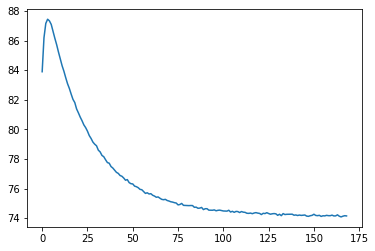

In [253]:
%matplotlib inline
plt.plot(np.array(epoch_loss))
plt.show()

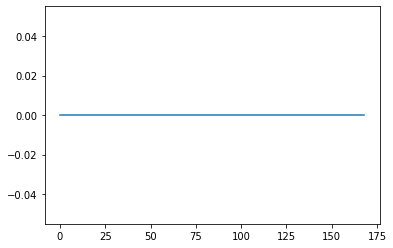

In [259]:
%matplotlib inline
#plt.plot(np.array(precision))
#plt.plot(np.array(accuracy))
plt.plot(np.array(recall))
plt.show()

In [256]:
a = np.array([0, 1.0])
b = np.array([1, 1])
precision_score(a,b)

0.5

In [261]:
from torchsampler import ImbalancedDatasetSampler

ModuleNotFoundError: No module named 'torchsampler'